In [1]:
import pandas as pd
import numpy as np
import os

from copy import deepcopy

from utils.multiprocessing import ensemble_create_cases, ensemble_execute, print_args
import matplotlib.pyplot as plt

import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
## global classes
class ReinforcementLearningTradingAgent:
    def __init__(self, price_dat, reward_dat, index, state_func=None, action_dict=None, **kwargs):
        self.price_dat = price_dat
        self.reward_dat = reward_dat
        self.index = index

        # learning related
        self.pol = None
        self.Q = {}
        self.Sf = state_func
        self.A = action_dict

        # training proecss related
        self.trained = False
        self.N = 0

        # evaluation related
        self._eval = {}
        self._summary = None

        # misc
        self.kwargs = kwargs

    @print_args
    def delay_init(self, state_func, action_dict):
        self.Sf = state_func
        self.A = action_dict

    # def transform(self, func, replace_raw=False):
    #     self.price_dat = func(self.price_dat_raw)
    #     if replace_raw:
    #         self.price_dat_raw = self.price_dat.copy()
    #     return self.price_dat

    # @print_args
    def extract_policy(self):
        self.pol = {q: sorted(self.Q[q].items(), key=lambda x: x[1], reverse=True)[0][0] for q in self.Q}
        # return self.pol

    # @print_args
    def evaluate_policy(self):
        # print(f"{_prev=:.6f} {_curr=:.6f} {_next=:.6f}")
        res = []

        for i in range(len(self.index)):
            states = self.price_dat[i]
            pair_ret = self.reward_dat[i][0]
            direction = self.A.get(self.pol.get(tuple([self.Sf(_state) for _state in states]), None), 0)
            res.append(direction * pair_ret)

        self._eval.update({self.N: res})
        # return pd.Series(res, index=self.index[:len(res)])

    def get_action(self, state):
        sa = self.Q.get(state, {})
        ra = [(r, a) for a, r in sa.items()]
        if ra:
            best_r, best_a = sorted(ra, reverse=True)[0]
            return best_r, best_a
        else:
            return 0, np.random.choice(list(self.A.keys()))

    def train(self, n_episodes, alpha_start=0.5, alpha_end=0.05, gamma=0.9, S=-0.005, J=0.9, verbose=False):
        alpha_step = (alpha_start - alpha_end) / n_episodes
        alpha = alpha_start

        for i in range(n_episodes):
            # init
            states = deepcopy(self.price_dat)
            rewards = deepcopy(self.reward_dat)
            state, _ = states.pop(0), 0
            state = tuple([self.Sf(_state) for _state in state])

            self.N += 1
            while states:
                best_r, best_a = self.get_action(state)
                exec_a = np.random.choice(list(self.A.keys()),
                                          p=[J if (_a == best_a) else (1 - J) / (len(self.A.keys()) - 1) for _a in
                                             self.A.keys()])

                # execution
                exec_r = self.A[exec_a] * rewards.pop(0)[0] + S * (self.A[exec_a] == 0)

                # learning
                new_state = tuple([self.Sf(_state) for _state in states.pop(0)])
                old_q = self.Q.get(state, {}).get(exec_a, 0)
                new_r = self.get_action(new_state)[0]
                new_q = old_q + alpha * (exec_r + gamma * new_r - old_q)
                self.Q[state] = {**self.Q.get(state, {}), **{exec_a: new_q}}
                state = new_state

                # self.N += 1
                # for _prev, _curr, _next in zip(np.append(1, self.price_dat[:-1]), self.price_dat, np.append(self.price_dat[1:], 1)):
                #     # state evaluation
                #     state = self.Sf(_prev, _curr, _next)
                #     best_r, best_a = self.get_action(state)
                #     # print(_next, _curr)
                #     exec_a = np.random.choice(list(self.A.keys()), p=[J if (_a == best_a) else (1-J)/(len(self.A.keys())-1) for _a in self.A.keys()])
                #
                #     # execution
                #     exec_r = self.A[exec_a] * ((_next / _curr) - 1) + S * (self.A[exec_a] == 0)
                #
                #     # learning
                #     old_q = self.Q.get(state, {}).get(exec_a, 0)
                #     new_r = self.get_action(self.Sf(_curr, _next, None))[0]
                #     new_q = old_q + alpha * (exec_r + gamma * new_r - old_q)
                #     self.Q[state] = {**self.Q.get(state, {}), **{exec_a: new_q}}

                # extract & evaluate policy
            self.extract_policy()
            self.evaluate_policy()
            alpha -= alpha_step
            print(f" EPISODE COMPLETED: {self.N} ".center(30, "-"))

    def summary(self):
        if self._summary is None:
            fig, (ax, bx) = plt.subplots(2, 1, figsize=(10, 8))
            episodes = pd.DataFrame(self._eval, index=self.index).cumsum()
            episodes.plot(ax=ax)
            episodes.iloc[-1].plot(ax=bx)
            episodes.iloc[-1].rolling(20, min_periods=1).mean().plot()
            ax.get_legend().remove()
            plt.tight_layout()
            self._summary = episodes
        return self._summary


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(5, 64)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(64, 3)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

In [3]:
## global vars
# data preprocessing
csvs_px_dir = os.listdir('data')
csvs_px = [pd.read_csv(os.path.join('data', und_name), index_col=0, parse_dates=True) for und_name in csvs_px_dir]

for und_name, und_price in zip(csvs_px_dir, csvs_px):
    und_price.columns = [und_name.split(".")[1]]

und_prices = pd.concat(csvs_px, axis=1)
hs_prices = und_prices[['HSI', 'HSCE']].pct_change().dropna()
cs_prices = und_prices[['CSI500', 'CSI1000I']].pct_change().dropna()
us_prices = und_prices[['SPX', 'NDX']].pct_change().dropna()

t1 = lambda dat: (1 + dat.values).cumprod(axis=0)
t2 = lambda dat: dat[:, 0] / dat[:, 1]
t3 = lambda dat: dat / dat.shift(260).fillna(1)

# REINFORCE vars
# parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')
# parser.add_argument('--gamma', type=float, default=0.99, metavar='G')
# parser.add_argument('--seed', type=int, default=543, metavar='N')
# parser.add_argument('--render', action='store_true')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N')
# args = parser.parse_args()
args = argparse.Namespace(gamma=0.95, seed=543, render=False, log_interval=10)
torch.manual_seed(args.seed)

# env = gym.make('CartPole-v1')
# env.reset(seed=args.seed)

<AxesSubplot:xlabel='date,None'>

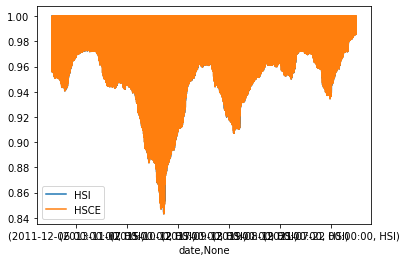

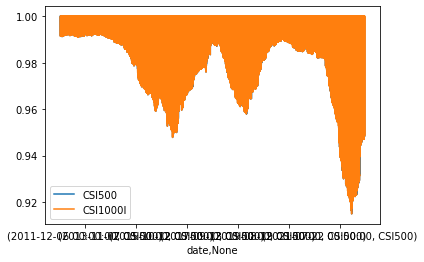

In [4]:
# data plots
hs_corr = hs_prices.rolling(260).corr(pairwise=True)
hs_corr.unstack()[[(hs_prices.columns)]]
hs_corr.plot()

cs_corr = cs_prices.rolling(260).corr(pairwise=True)
cs_corr.unstack()[[(cs_prices.columns)]]
cs_corr.plot()

In [30]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + args.gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def reinforce():
    ep_rewards = []
    running_rewards = []
    running_reward = 0
    ts = pd.DataFrame(t2(t1(cs_prices)), index=cs_prices.index)
    ts_train = pd.concat([ts.shift(i) for i in range(5, 0, -1)] + [ts.pct_change().shift(-1), ], axis=1).dropna()
    reward_mapper = {0: -1, 1: 0, 2: 1}

    # for i_episode in count(1):
    for i_episode in range(5000):
        # shuffle?
        ts_train = ts_train.sample(frac=1)

        states, rewards = ts_train.iloc[:, :5].values.tolist(), ts_train.iloc[:, 5:].values.tolist()
        state, ep_reward = states.pop(0), 0

        # for t in range(1, 10000):  # Don't infinite loop while learning
        while states:
            action = select_action(np.array(state))
            # state, reward, done, _ = env.step(action)
            state, reward = np.array(states.pop(0)), reward_mapper[action] * rewards.pop(0)[0]
            policy.rewards.append(reward)
            ep_reward += reward

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        ep_rewards.append(ep_reward)
        running_rewards.append(running_reward)
        if i_episode % args.log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                i_episode, ep_reward, running_reward))

    return ep_rewards, running_rewards

In [31]:
ep_rewards, running_rewards = reinforce()

Episode 0	Last reward: -0.38	Average reward: -0.02
Episode 10	Last reward: -0.05	Average reward: -0.03
Episode 20	Last reward: 0.19	Average reward: -0.02
Episode 30	Last reward: 0.16	Average reward: 0.03
Episode 40	Last reward: -0.08	Average reward: 0.03
Episode 50	Last reward: 0.08	Average reward: 0.04
Episode 60	Last reward: 0.16	Average reward: 0.04
Episode 70	Last reward: -0.01	Average reward: 0.08
Episode 80	Last reward: 0.07	Average reward: 0.06
Episode 90	Last reward: 0.08	Average reward: 0.07
Episode 100	Last reward: 0.19	Average reward: 0.06
Episode 110	Last reward: 0.10	Average reward: 0.07
Episode 120	Last reward: -0.02	Average reward: 0.06
Episode 130	Last reward: 0.05	Average reward: 0.06
Episode 140	Last reward: 0.07	Average reward: 0.06
Episode 150	Last reward: 0.06	Average reward: 0.07
Episode 160	Last reward: 0.08	Average reward: 0.07
Episode 170	Last reward: 0.06	Average reward: 0.08
Episode 180	Last reward: 0.11	Average reward: 0.08
Episode 190	Last reward: 0.16	Aver

In [25]:
def reinforce_backtest():
    ts = pd.DataFrame(t2(t1(cs_prices)), index=cs_prices.index)
    ts_train = pd.concat([ts.shift(i) for i in range(5, 0, -1)] + [ts.pct_change().shift(-1), ], axis=1).dropna()
    reward_mapper = {0: -1, 1: 0, 2: 1}

    backtest_rewards = []

    states, rewards = ts_train.iloc[:, :5].values.tolist(), ts_train.iloc[:, 5:].values.tolist()
    state, ep_reward = states.pop(0), 0

    while states:
        action = select_action(np.array(state))
        state, reward = np.array(states.pop(0)), reward_mapper[action] * rewards.pop(0)[0]
        backtest_rewards.append(reward)

    return backtest_rewards

## Policy Gradient Method

<AxesSubplot:title={'center':'Policy Gradient REINFORCE rewards'}>

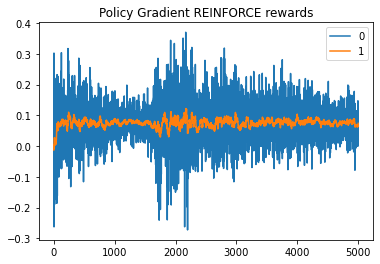

In [28]:
pd.DataFrame(zip(ep_rewards, running_rewards)).plot(title='Policy Gradient REINFORCE rewards')

<AxesSubplot:title={'center':'Policy Gradient Latest Ep Backtest'}>

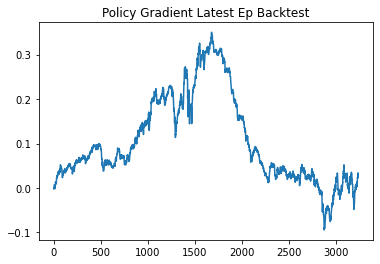

In [29]:
pd.Series(reinforce_backtest()).cumsum().plot(title='Policy Gradient Latest Ep Backtest')

<AxesSubplot:title={'center':'Policy Gradient REINFORCE shuffled rewards'}>

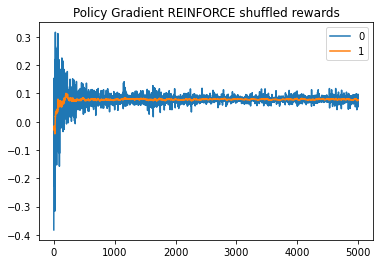

In [32]:
pd.DataFrame(zip(ep_rewards, running_rewards)).plot(title='Policy Gradient REINFORCE shuffled rewards')

<AxesSubplot:title={'center':'Policy Gradient shuffled Latest Ep Backtest'}>

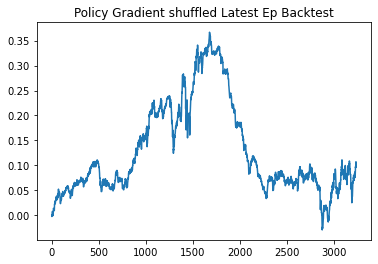

In [33]:
pd.Series(reinforce_backtest()).cumsum().plot(title='Policy Gradient shuffled Latest Ep Backtest')

## Q Learning

In [5]:
def q_learning(price_dat, norm=False):
    # global opts
    A1 = {'B': 1, 'N': 0, 'S': -1}
    A2 = {'B': 1, 'LB': 0.5, 'N': 0, 'SB': -0.5, 'S': -1}
    RLTA = ReinforcementLearningTradingAgent

    # global init
    # step 1: this is necessary to create pairwise POD
    # step 2: this transform is optional, but recommended
    dat = pd.DataFrame(t2(t1(price_dat)), index=price_dat.index)
    dat_train = pd.concat([dat.shift(i) for i in range(2, 0, -1)] + [dat.pct_change().shift(-1), ], axis=1).dropna()
    if norm:
        dat = t3(dat)
        states, rewards = t3(dat_train.iloc[:, :2]).values.tolist(), dat_train.iloc[:, 2:].values.tolist()
    else:
        states, rewards = dat_train.iloc[:, :2].values.tolist(), dat_train.iloc[:, 2:].values.tolist()
    rl_agent = RLTA(price_dat=states, reward_dat=rewards, index=dat_train.index)

    dat.plot(title="Pair premium or discount")
    plt.tight_layout()
    plt.show()

    def S(x):
        return np.digitize(x, np.linspace(0.7, 1.3, 31))

    def M(rl_agent, state_func, action_dict, **kwargs):
        # opt args
        J = kwargs.get('J', 0.8)        # explore vs exploit coefficient
        S = kwargs.get('S', -0.05)     # inaction penalty - loss of op cost

        # copy init
        _rl_agent = deepcopy(rl_agent)
        _rl_agent.delay_init(state_func, action_dict)

        # train & extract policy, call evaluate_policy() to do backtesting
        _rl_agent.train(n_episodes=1000, J=J, S=S)
        _rl_agent.extract_policy()
        return _rl_agent

    # do ensemble multi eval
    # e_cases: parametric input, otherwise pass as kwargs in ensemble_execute() for func partial
    e_cases = ensemble_create_cases({
        "action_dict": [A1, A2, ],
        "J": [0.8, 0.6, ]
    })
    # e_res = ensemble_execute(func=M, rl_agent=rl_agent, state_func=S, cases=e_cases)

    # demo: to run a singular case for debugging purpose
    res = M(rl_agent=rl_agent, state_func=S, action_dict=A2, J=0.6)
    res.summary()
    return res

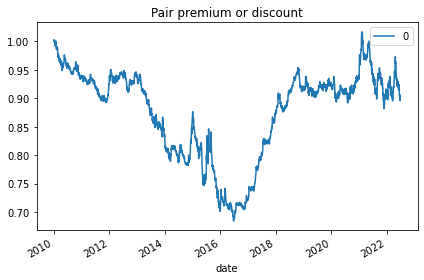

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7fda61381b50>, <function q_learning.<locals>.S at 0x7fda813dd9d0>, <class 'dict'>], kwargs []
---- EPISODE COMPLETED: 1 ----
---- EPISODE COMPLETED: 2 ----
---- EPISODE COMPLETED: 3 ----
---- EPISODE COMPLETED: 4 ----
---- EPISODE COMPLETED: 5 ----
---- EPISODE COMPLETED: 6 ----
---- EPISODE COMPLETED: 7 ----
---- EPISODE COMPLETED: 8 ----
---- EPISODE COMPLETED: 9 ----
--- EPISODE COMPLETED: 10 ----
--- EPISODE COMPLETED: 11 ----
--- EPISODE COMPLETED: 12 ----
--- EPISODE COMPLETED: 13 ----
--- EPISODE COMPLETED: 14 ----
--- EPISODE COMPLETED: 15 ----
--- EPISODE COMPLETED: 16 ----
--- EPISODE COMPLETED: 17 ----
--- EPISODE COMPLETED: 18 ----
--- EPISODE COMPLETED: 19 ----
--- EPISODE COMPLETED: 20 ----
--- EPISODE COMPLETED: 21 ----
--- EPISODE COMPLETED: 22 ----
--- EPISODE COMPLETED: 23 ----
--- EPISODE COMPLETED: 24 ----
--- EPISODE COMPLETED: 25 ----
--- EPISODE COMPLETED: 26 ----
--- EPISODE CO

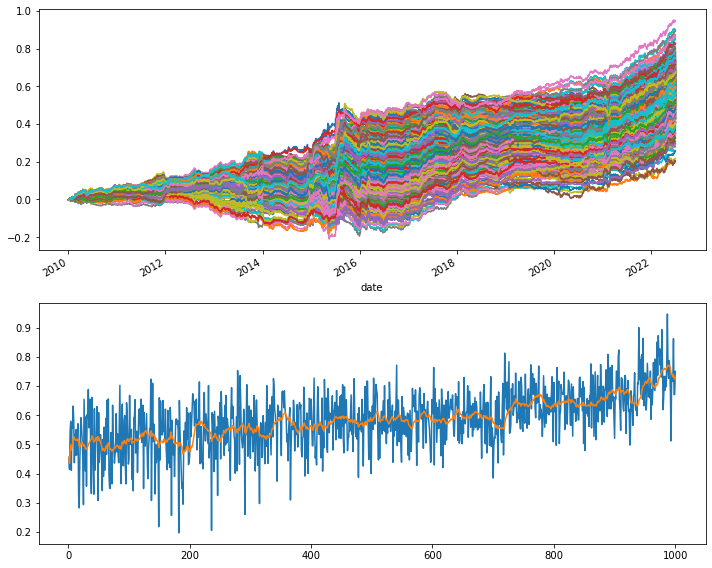

In [6]:
# M(rl_agent=rl_agent, state_func=S, action_dict=A2, J=0.6)
res = q_learning(cs_prices)

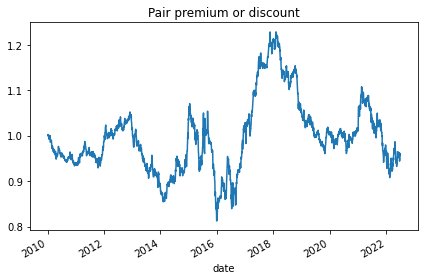

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff552add280>, <function q_learning.<locals>.S at 0x7ff586f4f670>, <class 'dict'>], kwargs []
--- EPISODE REMAINING: 499 ---
--- EPISODE REMAINING: 498 ---
--- EPISODE REMAINING: 497 ---
--- EPISODE REMAINING: 496 ---
--- EPISODE REMAINING: 495 ---
--- EPISODE REMAINING: 494 ---
--- EPISODE REMAINING: 493 ---
--- EPISODE REMAINING: 492 ---
--- EPISODE REMAINING: 491 ---
--- EPISODE REMAINING: 490 ---
--- EPISODE REMAINING: 489 ---
--- EPISODE REMAINING: 488 ---
--- EPISODE REMAINING: 487 ---
--- EPISODE REMAINING: 486 ---
--- EPISODE REMAINING: 485 ---
--- EPISODE REMAINING: 484 ---
--- EPISODE REMAINING: 483 ---
--- EPISODE REMAINING: 482 ---
--- EPISODE REMAINING: 481 ---
--- EPISODE REMAINING: 480 ---
--- EPISODE REMAINING: 479 ---
--- EPISODE REMAINING: 478 ---
--- EPISODE REMAINING: 477 ---
--- EPISODE REMAINING: 476 ---
--- EPISODE REMAINING: 475 ---
--- EPISODE REMAINING: 474 ---
--- EPISODE RE

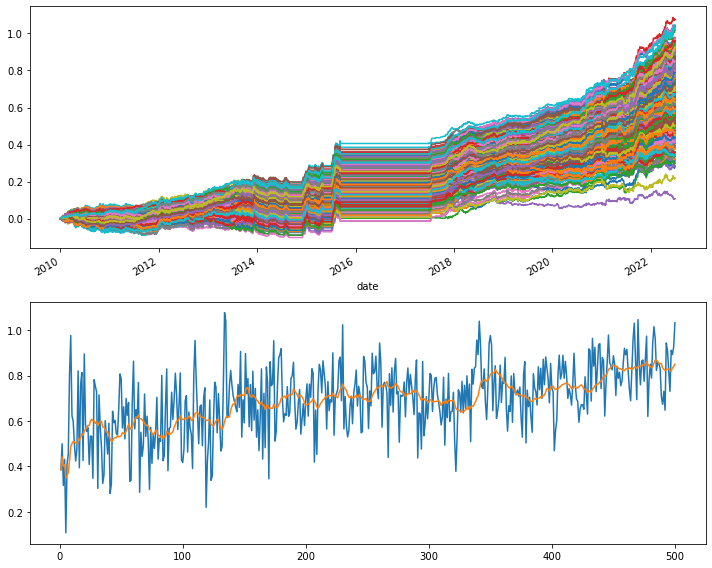

In [50]:
# M(rl_agent=rl_agent, state_func=S, action_dict=A2, J=0.6)
# normalizer ON
res = q_learning(cs_prices, norm=True)

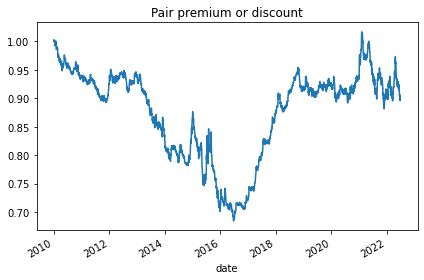

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff5850c9670>, <function q_learning.<locals>.S at 0x7ff5846bc670>, <class 'dict'>], kwargs []
--- EPISODE REMAINING: 499 ---
--- EPISODE REMAINING: 498 ---
--- EPISODE REMAINING: 497 ---
--- EPISODE REMAINING: 496 ---
--- EPISODE REMAINING: 495 ---
--- EPISODE REMAINING: 494 ---
--- EPISODE REMAINING: 493 ---
--- EPISODE REMAINING: 492 ---
--- EPISODE REMAINING: 491 ---
--- EPISODE REMAINING: 490 ---
--- EPISODE REMAINING: 489 ---
--- EPISODE REMAINING: 488 ---
--- EPISODE REMAINING: 487 ---
--- EPISODE REMAINING: 486 ---
--- EPISODE REMAINING: 485 ---
--- EPISODE REMAINING: 484 ---
--- EPISODE REMAINING: 483 ---
--- EPISODE REMAINING: 482 ---
--- EPISODE REMAINING: 481 ---
--- EPISODE REMAINING: 480 ---
--- EPISODE REMAINING: 479 ---
--- EPISODE REMAINING: 478 ---
--- EPISODE REMAINING: 477 ---
--- EPISODE REMAINING: 476 ---
--- EPISODE REMAINING: 475 ---
--- EPISODE REMAINING: 474 ---
--- EPISODE RE

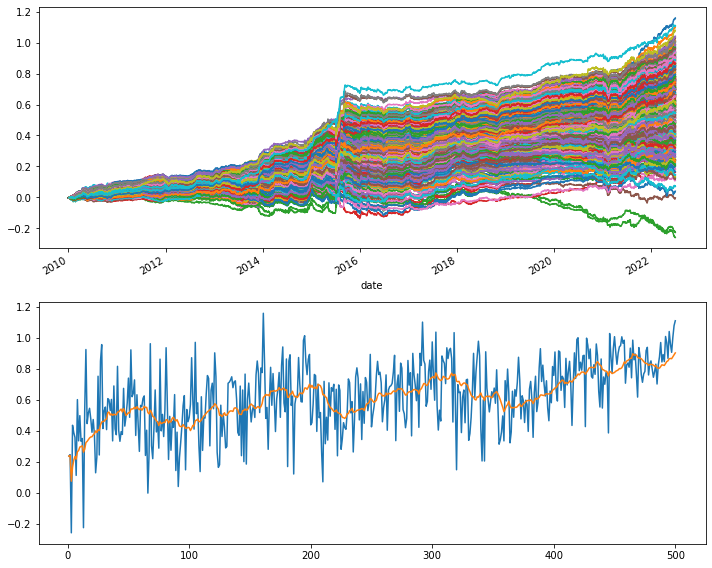

In [52]:
# M(rl_agent=rl_agent, state_func=S, action_dict=A2, J=0.8)
# exploit = 0.8, explore = 0.2
res = q_learning(cs_prices)

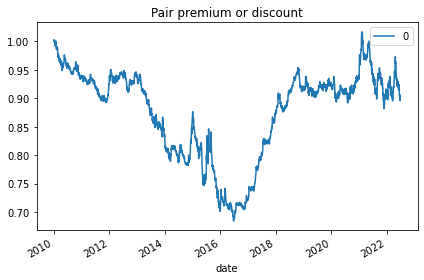

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff584691040>, <function q_learning.<locals>.S at 0x7ff567a2e4c0>, <class 'dict'>], kwargs []
---- EPISODE COMPLETED: 1 ----
---- EPISODE COMPLETED: 2 ----
---- EPISODE COMPLETED: 3 ----
---- EPISODE COMPLETED: 4 ----
---- EPISODE COMPLETED: 5 ----
---- EPISODE COMPLETED: 6 ----
---- EPISODE COMPLETED: 7 ----
---- EPISODE COMPLETED: 8 ----
---- EPISODE COMPLETED: 9 ----
--- EPISODE COMPLETED: 10 ----
--- EPISODE COMPLETED: 11 ----
--- EPISODE COMPLETED: 12 ----
--- EPISODE COMPLETED: 13 ----
--- EPISODE COMPLETED: 14 ----
--- EPISODE COMPLETED: 15 ----
--- EPISODE COMPLETED: 16 ----
--- EPISODE COMPLETED: 17 ----
--- EPISODE COMPLETED: 18 ----
--- EPISODE COMPLETED: 19 ----
--- EPISODE COMPLETED: 20 ----
--- EPISODE COMPLETED: 21 ----
--- EPISODE COMPLETED: 22 ----
--- EPISODE COMPLETED: 23 ----
--- EPISODE COMPLETED: 24 ----
--- EPISODE COMPLETED: 25 ----
--- EPISODE COMPLETED: 26 ----
--- EPISODE CO

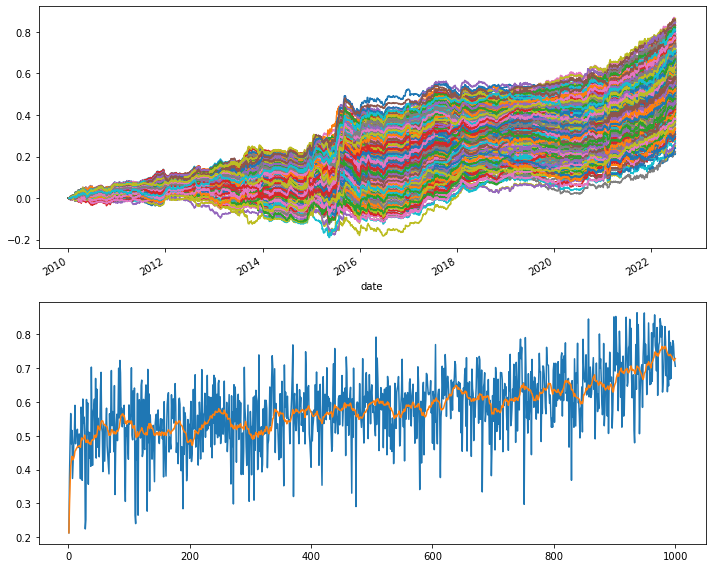

In [70]:
# 2-step lookback
q_learning(cs_prices)

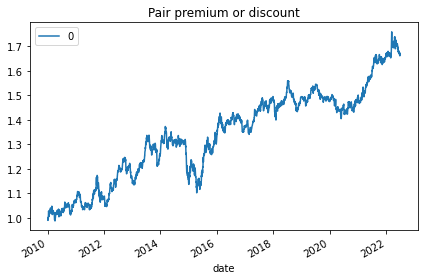

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff501b455b0>, <function q_learning.<locals>.S at 0x7ff4f1694b80>, <class 'dict'>], kwargs []
---- EPISODE COMPLETED: 1 ----
---- EPISODE COMPLETED: 2 ----
---- EPISODE COMPLETED: 3 ----
---- EPISODE COMPLETED: 4 ----
---- EPISODE COMPLETED: 5 ----
---- EPISODE COMPLETED: 6 ----
---- EPISODE COMPLETED: 7 ----
---- EPISODE COMPLETED: 8 ----
---- EPISODE COMPLETED: 9 ----
--- EPISODE COMPLETED: 10 ----
--- EPISODE COMPLETED: 11 ----
--- EPISODE COMPLETED: 12 ----
--- EPISODE COMPLETED: 13 ----
--- EPISODE COMPLETED: 14 ----
--- EPISODE COMPLETED: 15 ----
--- EPISODE COMPLETED: 16 ----
--- EPISODE COMPLETED: 17 ----
--- EPISODE COMPLETED: 18 ----
--- EPISODE COMPLETED: 19 ----
--- EPISODE COMPLETED: 20 ----
--- EPISODE COMPLETED: 21 ----
--- EPISODE COMPLETED: 22 ----
--- EPISODE COMPLETED: 23 ----
--- EPISODE COMPLETED: 24 ----
--- EPISODE COMPLETED: 25 ----
--- EPISODE COMPLETED: 26 ----
--- EPISODE CO

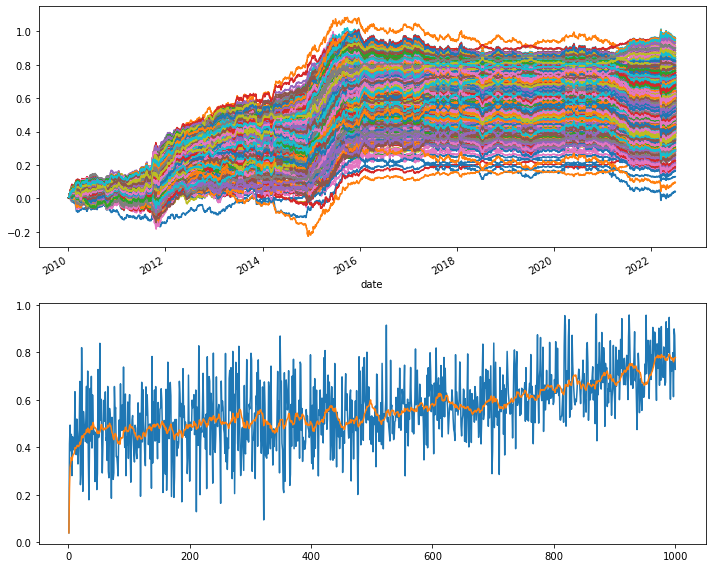

In [69]:
# hang seng no norm
q_learning(hs_prices)

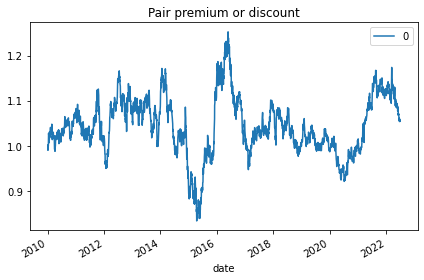

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff4e4ea44f0>, <function q_learning.<locals>.S at 0x7ff4a6da11f0>, <class 'dict'>], kwargs []
---- EPISODE COMPLETED: 1 ----
---- EPISODE COMPLETED: 2 ----
---- EPISODE COMPLETED: 3 ----
---- EPISODE COMPLETED: 4 ----
---- EPISODE COMPLETED: 5 ----
---- EPISODE COMPLETED: 6 ----
---- EPISODE COMPLETED: 7 ----
---- EPISODE COMPLETED: 8 ----
---- EPISODE COMPLETED: 9 ----
--- EPISODE COMPLETED: 10 ----
--- EPISODE COMPLETED: 11 ----
--- EPISODE COMPLETED: 12 ----
--- EPISODE COMPLETED: 13 ----
--- EPISODE COMPLETED: 14 ----
--- EPISODE COMPLETED: 15 ----
--- EPISODE COMPLETED: 16 ----
--- EPISODE COMPLETED: 17 ----
--- EPISODE COMPLETED: 18 ----
--- EPISODE COMPLETED: 19 ----
--- EPISODE COMPLETED: 20 ----
--- EPISODE COMPLETED: 21 ----
--- EPISODE COMPLETED: 22 ----
--- EPISODE COMPLETED: 23 ----
--- EPISODE COMPLETED: 24 ----
--- EPISODE COMPLETED: 25 ----
--- EPISODE COMPLETED: 26 ----
--- EPISODE CO

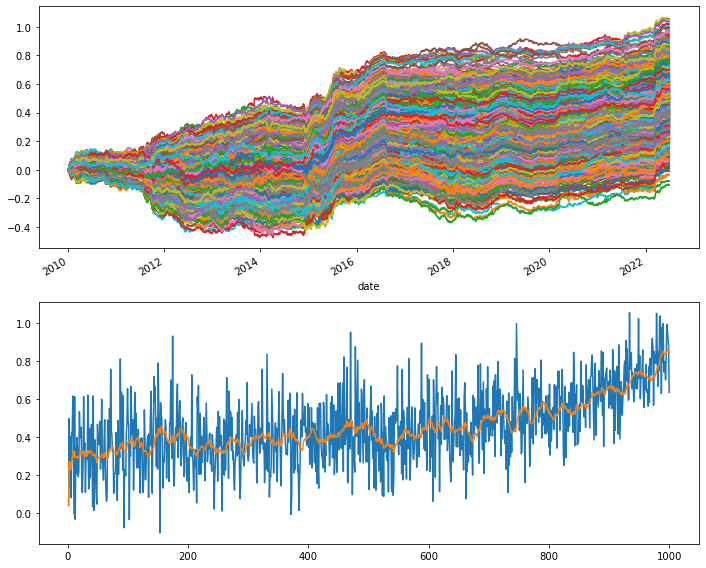

In [83]:
# hs norm
q_learning(hs_prices, norm=True)

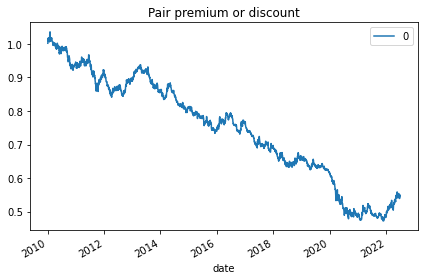

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff4c8e36e50>, <function q_learning.<locals>.S at 0x7ff4c984ec10>, <class 'dict'>], kwargs []
---- EPISODE COMPLETED: 1 ----
---- EPISODE COMPLETED: 2 ----
---- EPISODE COMPLETED: 3 ----
---- EPISODE COMPLETED: 4 ----
---- EPISODE COMPLETED: 5 ----
---- EPISODE COMPLETED: 6 ----
---- EPISODE COMPLETED: 7 ----
---- EPISODE COMPLETED: 8 ----
---- EPISODE COMPLETED: 9 ----
--- EPISODE COMPLETED: 10 ----
--- EPISODE COMPLETED: 11 ----
--- EPISODE COMPLETED: 12 ----
--- EPISODE COMPLETED: 13 ----
--- EPISODE COMPLETED: 14 ----
--- EPISODE COMPLETED: 15 ----
--- EPISODE COMPLETED: 16 ----
--- EPISODE COMPLETED: 17 ----
--- EPISODE COMPLETED: 18 ----
--- EPISODE COMPLETED: 19 ----
--- EPISODE COMPLETED: 20 ----
--- EPISODE COMPLETED: 21 ----
--- EPISODE COMPLETED: 22 ----
--- EPISODE COMPLETED: 23 ----
--- EPISODE COMPLETED: 24 ----
--- EPISODE COMPLETED: 25 ----
--- EPISODE COMPLETED: 26 ----
--- EPISODE CO

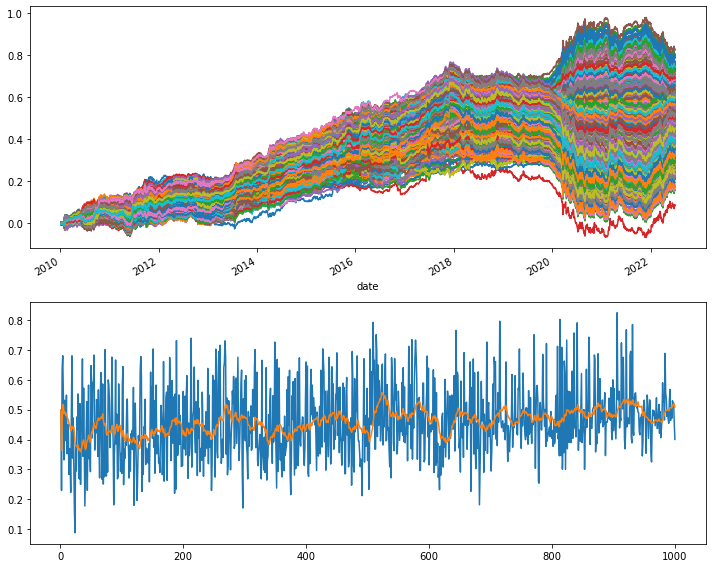

In [71]:
# us no norm
q_learning(us_prices)

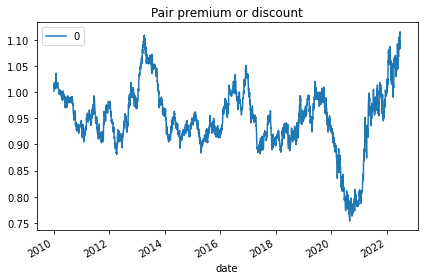

Calling delay_init with args=[<__main__.ReinforcementLearningTradingAgent object at 0x7ff5576bfe50>, <function q_learning.<locals>.S at 0x7ff4b2ba7d30>, <class 'dict'>], kwargs []
---- EPISODE COMPLETED: 1 ----
---- EPISODE COMPLETED: 2 ----
---- EPISODE COMPLETED: 3 ----
---- EPISODE COMPLETED: 4 ----
---- EPISODE COMPLETED: 5 ----
---- EPISODE COMPLETED: 6 ----
---- EPISODE COMPLETED: 7 ----
---- EPISODE COMPLETED: 8 ----
---- EPISODE COMPLETED: 9 ----
--- EPISODE COMPLETED: 10 ----
--- EPISODE COMPLETED: 11 ----
--- EPISODE COMPLETED: 12 ----
--- EPISODE COMPLETED: 13 ----
--- EPISODE COMPLETED: 14 ----
--- EPISODE COMPLETED: 15 ----
--- EPISODE COMPLETED: 16 ----
--- EPISODE COMPLETED: 17 ----
--- EPISODE COMPLETED: 18 ----
--- EPISODE COMPLETED: 19 ----
--- EPISODE COMPLETED: 20 ----
--- EPISODE COMPLETED: 21 ----
--- EPISODE COMPLETED: 22 ----
--- EPISODE COMPLETED: 23 ----
--- EPISODE COMPLETED: 24 ----
--- EPISODE COMPLETED: 25 ----
--- EPISODE COMPLETED: 26 ----
--- EPISODE CO

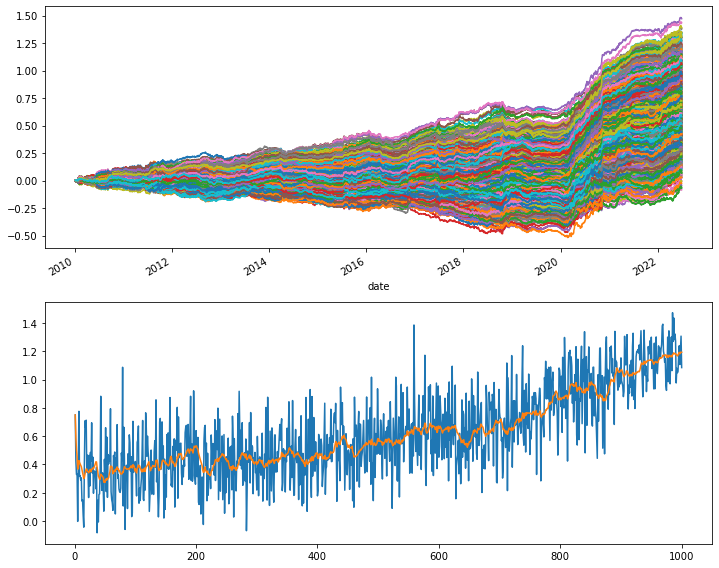

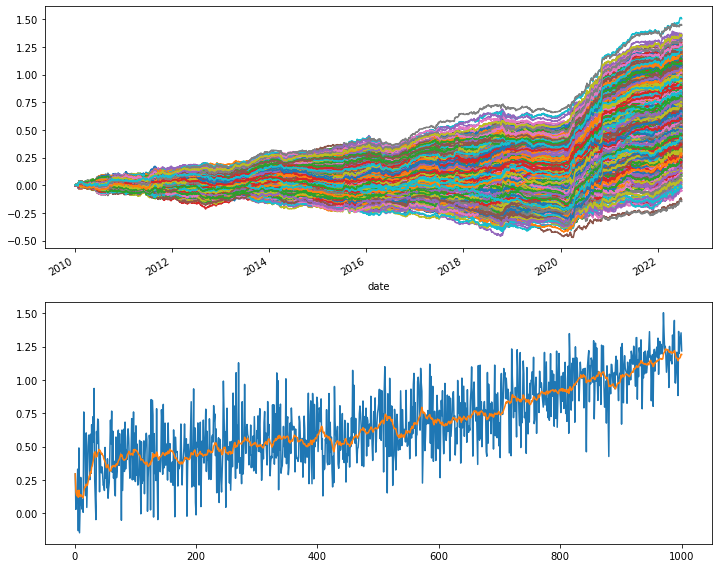

In [81]:
# us norm
q_learning(us_prices, norm=True)